## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


* user_id	идентификатор пользователя, зашедшего на сайт
* date	дата захода
* group	группа теста (контрольная — А или тестовая — B)
* purchase	признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
* price	цена купленного тура (если покупка не состоялась, цена равна 0)

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Сравнение дат начала тестирования для групп
print('Даты начала тестирования для групп A и B совпадают: ', end='')
print(data[data['group']=='A']['date'].min() == 
      data[data['group']=='B']['date'].min())

# Сравнение дат конца тестирования для групп
print('Даты окончания тестирования для групп A и B совпадают: ', end='')
print(data[data['group']=='A']['date'].max() == 
      data[data['group']=='B']['date'].max())

# Длительность теста
print('Тест продлился: с', end=' ')
print(f"{data[data['group']=='A']['date'].min().date()} по", end=' ')
print(f"{data[data['group']=='A']['date'].max().date()}")

Даты начала тестирования для групп A и B совпадают: True
Даты окончания тестирования для групп A и B совпадают: True
Тест продлился: с 2021-01-02 по 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# Группировка по группам
data_group = data.groupby('group').agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

# Перевод суммарных покупок в миллионы
data_group['price'] = 1e-6 * data_group['price']

# Вывод таблицы
data_group.rename(columns={
    'user_id': 'Число посещений', 
    'purchase': 'Покупки', 
    'price': 'Сумма, млн'})

,Число посещений,Покупки,"Сумма, млн"
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# Создание множеств
user_set_a = set(data[(data['group'] == 'A')]['user_id'])
user_set_b = set(data[(data['group'] == 'B')]['user_id'])

# Пересечение пользователей в 2х группах
user_intersection = user_set_a.intersection(user_set_b)

print(f'Количество "пересекающихся" пользователей: {len(user_intersection)}')

Количество "пересекающихся" пользователей: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [9]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

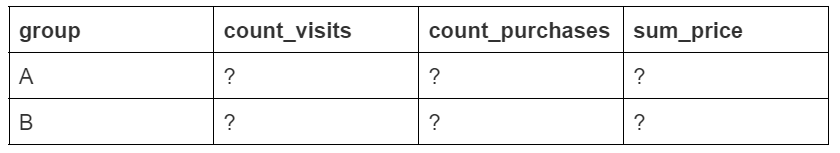
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [10]:
updated_data_group = updated_data.groupby(by='group').agg(
    {'user_id': 'count', 
     'purchase': 'sum', 
     'price': 'sum'}).rename(
    columns=
    {'user_id': 'count_visits', 
     'purchase': 'count_purchases', 
     'price': 'sum_price'})

display(updated_data_group)

print('-'*50)

print('Количество посещений сайта, группа A: ', end='')
print(f"{updated_data_group.loc['A', 'count_visits']}")

print('Количество посещений сайта, группа B: ', end='')
print(f"{updated_data_group.loc['B', 'count_visits']}")

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


--------------------------------------------------
Количество посещений сайта, группа A: 145307
Количество посещений сайта, группа B: 145381


In [11]:
# Различие между количествами посещений для групп A и B
diff_percent = round(100*(updated_data_group.loc['B', 'count_visits'] - 
                          updated_data_group.loc['A', 'count_visits'])/
                     updated_data_group.loc['A', 'count_visits'], 3)

print('Различия в количестве посещений для 2х групп: ', end='')
print(f'{diff_percent} %')

Различия в количестве посещений для 2х групп: 0.051 %


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Поскольку различие между количеством посещений сайта для контрольной и тестовой групп составляет около 0.05% (т.е. выборка разбита по группам практически в соотношении 50/50), то выборку можно считать сбалансированной.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [12]:
# Добавление конверсии
updated_data_group['conversion'] = round((100*updated_data_group['count_purchases']/
                                    updated_data_group['count_visits']), 2)

# Добавление среднего чека
updated_data_group['mean_check'] = round(updated_data_group['sum_price']/
                                    updated_data_group['count_purchases'])

updated_data_group

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Из обновленной таблицы следует, что для контрольной группы (группа A) величина конверсии покупки немного больше (~0.14%), чем в тестовой группе B. Т.е. величины конверсии для групп практически равны. 
Однако при этом в тестовой группе B величина среднего чека покупки на ~8.5% больше чем в группе A. Вероятно, в группе B клиенты в среднем приобретают более дорогие туры.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [13]:
# Сводная таблица - количество продаж от группы и цены тура.
# Для удобства сравнения по группам сначала идет цена тура, а затем группа
price_group = updated_data.groupby(['price', 'group']).agg(
    {'purchase':'sum'})

# Туры с нулевой ценой (т.е. варианты без покупки) исключены
price_group = price_group[price_group['purchase']!=0]

display(price_group)

purchase
price  group          
10000  A          5182
       B          5201
60000  A          5271
       B          1730
100000 A          1832
       B          5227
150000 A          3478
       B          3438
200000 A          1724
       B          1694

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Число туров по 60кр: 
       purchase
group          
A          5271
B          1730


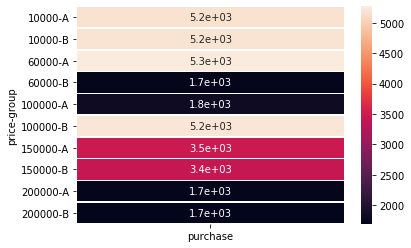

In [14]:
sns.heatmap(price_group, annot=True, linewidths=.5);

print('Число туров по 60кр: ')
print(f'{price_group.loc[60000]}')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Из таблицы следует, что туры на Мальдивы (200кр), Камчатку (150кр) и в Питер (10кр) интересуют покупателей из обеих групп примерно одинаково. Участников контрольной группы (А) в 3 раза больше, чем тестовой (B) интересуют туры в Турцию (60кр). Более дорогие туры в Таиланд (100кр) почти в три раза больше интересуют участников тестовой группы (B). 

По всей видимости тестовый вариант посадочной страницы побуждает покупать более дорогие туры в Таиланд, в то время как участники контрольной группы предпочитают не тратить лишние деньги и предпочитают Турцию. По всем остальным вариантам туров поведение покупателей примерно совпадает.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
# Группировка данных, сброс индекса, переименование столбца user_id
upd_data_group = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count', 
    'purchase': 'sum', 
    'price': 'sum'}).reset_index().rename(columns={'user_id': 'visits'})

# Ежедневные конверсия и средний чек
upd_data_group['daily_conversion'] = round(
    100*upd_data_group['purchase']/upd_data_group['visits'], 
    2)

upd_data_group['daily_mean_cheque'] = round(
    upd_data_group['price'] / upd_data_group['purchase']
)

upd_data_group.head()

,date,group,visits,purchase,price,daily_conversion,daily_mean_cheque
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


In [16]:
# Параметры на 03 января 2021г
upd_data_group[upd_data_group['date']=='2021-01-03'][['date', 
                                                      'group', 
                                                      'daily_conversion', 
                                                      'daily_mean_cheque']]

,date,group,daily_conversion,daily_mean_cheque
2,2021-01-03,A,11.34,82888.0
3,2021-01-03,B,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [17]:
# Столбцы с кумулятивными признаками: посещения, число покупок, сумма покупок
upd_data_group['cum_visits'] = upd_data_group.groupby(
    ['group'])['visits'].cumsum()

upd_data_group['cum_purchase'] = upd_data_group.groupby(
    ['group'])['purchase'].cumsum()

upd_data_group['cum_price'] = upd_data_group.groupby(
    ['group'])['price'].cumsum()

# Кумулятивная конверсия и средний чек
upd_data_group['cum_conversion'] = (100 * 
                                    upd_data_group['cum_purchase'] / 
                                    upd_data_group['cum_visits'])

upd_data_group['cum_mean_cheque'] = (upd_data_group['cum_price'] / 
                                     upd_data_group['cum_purchase'])

upd_data_group.head()

,date,group,visits,purchase,price,daily_conversion,daily_mean_cheque,cum_visits,cum_purchase,cum_price,cum_conversion,cum_mean_cheque
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.900599,81668.415530


In [19]:
# Маски для группы A, 12 янв 2021 и B, 20 янв 2021
mask_a = ((upd_data_group['group']=='A') & 
          (upd_data_group['date']=='2021-01-12'))

mask_b = ((upd_data_group['group']=='B') & 
          (upd_data_group['date']=='2021-01-20'))

print('Кумулятивная конверсия в группе B на 20 янв 2021г: ', end='')
print(f"{round(float(upd_data_group.loc[mask_b, 'cum_conversion']), 2)} %")

print('Кумулятивный средний чек в группе A на 12 янв 2021г: ', end='')
print(f"{round(float(upd_data_group.loc[mask_a, 'cum_mean_cheque']))} р")

Кумулятивная конверсия в группе B на 20 янв 2021г: 11.9 %
Кумулятивный средний чек в группе A на 12 янв 2021г: 81492 р


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

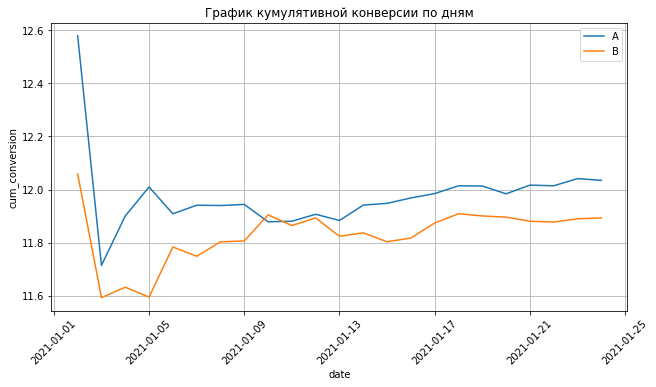

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])

# Кумулятивная конверсия 
sns.lineplot(
    data=upd_data_group,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax
)

# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')

# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)

ax.legend(['A', 'B'])

# задаём отображение сетки
ax.grid();

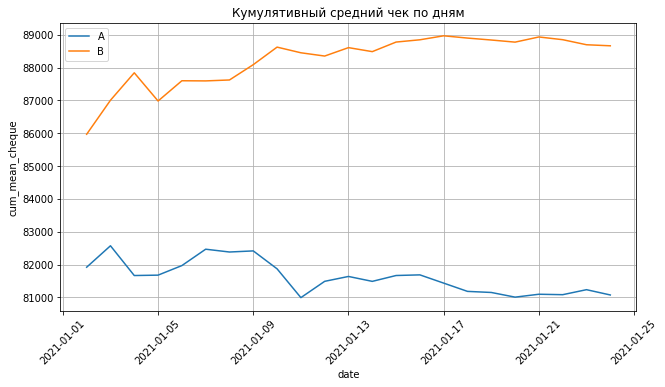

In [21]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])

# Кумулятивная конверсия 
sns.lineplot(
    data=upd_data_group,
    x='date',
    y='cum_mean_cheque',
    hue='group',
    ax=ax
)

# задаём подпись к графику
ax.set_title('Кумулятивный средний чек по дням')

# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)

ax.legend(['A', 'B'])

# задаём отображение сетки
ax.grid();

Как следует из графика кумулятивной конверсии по дням, в самом начале теста величина была подвержена сильным колебаниям, однако ближе к концу периода тестирование происходит стабилизация метрики. Конверсия группы A несколько больше, однако различия не значительны.

Величина кумулятивного среднего чека для группы A с самого начала теста несколько снижается, а для группы B, наоборот, увеличивается. Средний чек для группы A больше, чем для группы B. Максимальная разница между значениями достигается ближе к концу теста. Значения этой метрики в конце теста также стабильны.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [22]:
# Суммарное количество успехов и общее кол-во наблюдений
converted_piv = updated_data.groupby('group').agg({
    'user_id': 'count', 'purchase': 'sum'})

converted_piv

,user_id,purchase
group,,
A,145307,17487
B,145381,17290


In [23]:
# Гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'

# Уровень значимости
alpha = 0.05 

# p-value для z-теста для пропорции
_, p_value = proportions_ztest(
    count=converted_piv['purchase'], #число "успехов"
    nobs=converted_piv['user_id'], #общее число наблюдений
    alternative='larger',
)

print('p-value: ', round(p_value, 2))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Для проверки гипотезы о равенстве конверсий используется z-тест. По результатам проведения теста подтвердилась нулевая гипотеза об отсутствии различий между конверсиями для групп A и B.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [24]:
# Используются функции для границ интервала из модуля
def proportions_conf_interval(n, x_p, gamma=0.95):
    """
    Расчет границ доверительного интервала для пропорции
    n - размер выборки 
    x_p - выборочная пропорция
    gamma - доверительный интервал
    """
    # уровень значимости
    alpha = 1 - gamma
    
    # z критическое
    z_crit = -norm.ppf(alpha/2)
    
    # погрешность
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    
    # Левая и правая границы
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    
    # Кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """
    Расчет границ доверительного интервала для разницы пропорций
    n - список размеров выборок
    x_p - список выборочных пропорций
    """
    # Уровень значимости
    alpha = 1 - gamma
    
    # Выборочная разница конверсий для групп
    diff = xp[1] - xp[0]
    
    # z-критическое
    z_crit = -norm.ppf(alpha/2)
    
    # Погрешность
    eps = z_crit * (
        xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    
    # Границы интервала
    lower_bound = diff - eps
    upper_bound = diff + eps
    
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [25]:
# Данные для групп A и B
a_data = updated_data[updated_data['group']=='A']
b_data = updated_data[updated_data['group']=='B']

# Интервал для группы A
interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p=a_data['purchase'].mean()
)

interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    x_p=b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы A: {interval_a}')
print(f'Доверительный интервал для конверсии группы B: {interval_b}')

# Размеры и выборочные пропорции
n_ab = [a_data['user_id'].count(), b_data['user_id'].count()]
xp_ab = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# Доверительный интервал для разности конверсий
diff_interval = diff_proportions_conf_interval(n_ab, xp_ab)

print(f'Доверительный интервал для разности конверсий: {diff_interval}')

Доверительный интервал для конверсии группы A: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительный интевал для разности конверсий включает в себя нулевое значение. Отсюда можно сделать вывод, что варианты A и B равнозначны по метрике конверсии. Истинная разница в конверсии может быть как положительна, так и отрицательна, но при этом близка к нулю.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

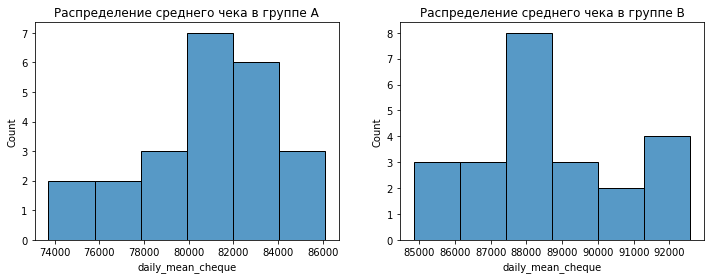

In [26]:
# Построение распределений среднего ежедневного чека
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Гистограммы
sns.histplot(x='daily_mean_cheque', 
             data=upd_data_group[upd_data_group['group']=='A'], 
             ax=axes[0])
sns.histplot(x='daily_mean_cheque', 
             data=upd_data_group[upd_data_group['group']=='B'], 
             ax=axes[1])

axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

In [27]:
# Гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

# Уровень значимости
alpha = 0.05

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_dcheque_a = shapiro(upd_data_group[
    upd_data_group['group']=='A']['daily_mean_cheque'])
shapiro_dcheque_b = shapiro(upd_data_group[
    upd_data_group['group']=='B']['daily_mean_cheque'])

print('p-value группы А', round(shapiro_dcheque_a.pvalue, 2))
print('p-value группы B', round(shapiro_dcheque_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if ((shapiro_dcheque_a.pvalue < alpha) or 
    (shapiro_dcheque_b.pvalue < alpha)):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Для проверки гипотезы о нормальности распределения ежедневного среднего чека для обеих групп используется тест Шапиро-Уилка. С уровнем значимости 0.05 распределения для обеих группах нормальные.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [28]:
# Гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

# Уровень значимости
alpha = 0.05

# вычисляем результат t-теста для выборок
ttest_mean_dcheque = ttest_ind(
    a=upd_data_group[upd_data_group['group']=='A']['daily_mean_cheque'], 
    b=upd_data_group[upd_data_group['group']=='B']['daily_mean_cheque'], 
    alternative='less'
)

print('p-value', round(ttest_mean_dcheque.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if ttest_mean_dcheque.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Для проверки гипотезы о равенстве средних ежедневных чеков используется t-тест. Согласно его результатам нулевая гипотеза может быть отвергнута, и, таким образом: Ежедневный средний чек в группе A меньше чем в B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [29]:
# Параметры выборочных среднего и стандартного отклонения для групп
mean_std_data = upd_data_group.groupby('group')['daily_mean_cheque'].agg(
    ('mean', 'std'))

mean_std_data

,mean,std
group,,
A,80969.347826,3096.388506
B,88575.739130,2196.705844


In [30]:
def tcrit_mean_interval(n, x_mean, x_std, gamma=0.95):
    """
    Доверительный интервал для среднего, t-распределение
    n - размер выборки
    x_mean - выборочное среднее
    x_std - выборочное стандартное отклонение 
    gamma - уровень надежности
    """
    # Число степеней свободы
    k = n - 1
    
    # Уровень значимости
    alpha = 1 - gamma
    
    # t-критическое
    t_crit = -t.ppf(alpha/2, k)
    
    # Погрешность
    eps = t_crit * x_std / (n**0.5)
    
    # Границы интервалов
    lower_bound = round(x_mean - eps)
    upper_bound = round(x_mean + eps)
    
    return lower_bound, upper_bound

In [31]:
# Вычисление интервалов
interval_a = tcrit_mean_interval(
    n=upd_data_group[upd_data_group['group']=='A'].shape[0], 
    x_mean=mean_std_data.loc['A', 'mean'], 
    x_std=mean_std_data.loc['A', 'std'])

interval_b = tcrit_mean_interval(
    n=upd_data_group[upd_data_group['group']=='B'].shape[0], 
    x_mean=mean_std_data.loc['B', 'mean'], 
    x_std=mean_std_data.loc['B', 'std'])

print('Доверительный интервал для среднего дневного чека для A: ', end='')
print(f'{interval_a}')

print('Доверительный интервал для среднего дневного чека для B: ', end='')
print(f'{interval_b}')

Доверительный интервал для среднего дневного чека для A: (79630, 82308)
Доверительный интервал для среднего дневного чека для B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечение между доверительными интервалами для ежедневных средних чеков для 2х групп отсутствует. Это говорит о том, что истинные средние значения с вероятностью не менее 95% не совпадут. А поскольку интервалы разнесены достаточно далеко друг от друга, то эта вероятность еще выше.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

#### Выводы
По результатам проведения A/B тестирования с двумя метриками для 2х вариантов посадочной страницы можно сделать следующие выводы:
* выбор варианта страницы не влияет на конверсию покупки тура на сайте - следует из подтверждения гипотезы о равенстве конверсии;
* предыдущий вывод также подтверждается тем, что границы интервала для разности конверсий имеют различные знаки;
* тестовый вариант B ведет к увеличению ежедневного среднего чека - это следует из опровержения гипотезы о равенстве средних ежедневных чеков;
* также предыдущий вывод подтверждается отсутствием пересечения доверительных интервалов для истинных средних ежедневных чеков;
* на основании вышесказанного, вариант стартовой страницы B является более предпочтительным для дальнейшего использования